In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## In this notebook, I will take a different approach. I will use Concepts like 
1. **Feature Engineering with - LabelEncoder, SimpleImputer, BOX-COX Transfomtion, IsolationForest, RobustScalar**
2. **Feature Selection with - SelectKBest**
3. **Normal Equation**
4. **RMLSE evaluation**
5. **Feature Importance with - SHAP Values**

## For more traditional approach, (EDA + Excellent Data Viz + XGBoost HyperParameter Tuning + Feature Engineering Tutorial)
you may visit:-[https://www.kaggle.com/code/pythonkumar/xgboost-hyperparameters-excellent-plots-acc-91?kernelSessionId=94478268]

In [2]:
import numpy as np
import pandas as pd

In [3]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
Id=test['Id']
train
# test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Drop some USELESS Columns

In [4]:
train=train.drop(columns=['SalePrice','Id'], axis=1)
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [5]:
test=test.drop(columns=['Id'], axis=1)
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# Changing Infinite to Nan

In [6]:
pd.set_option('mode.use_inf_as_na', True)

# Columns having Null Values

In [7]:
null_train=train.columns[train.isnull().any()]
null_train

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [8]:
null_test=test.columns[test.isnull().any()]
null_test

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

# Seperate Numerical & Categorical columns

In [9]:
num_train = train.select_dtypes(include=['int64','float64','UInt32'])
cat_train = train.select_dtypes(include=['object','string'])
num_train
# cat_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,240,366,0,112,0,0,0,0,4,2010


In [10]:
num_test = test.select_dtypes(include=['int64','float64','UInt32'])
cat_test = test.select_dtypes(include=['object','string'])
# num_test
cat_test

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
1455,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


# Handling Categorical Features

Most ML Models cannot work with non-numeric values, so we need to apply some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values.

* Nominal attributes consist of discrete categorical values with no notion or sense of order amongst them.
* Ordinal attributes are categorical attributes with a sense of order amongst the values.

In [11]:
# Label Encoding - This transformer should be used to encode 1 COLUMN at a Time
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat in cat_train:
    train[cat]=le.fit_transform(train[cat])
    
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2,3,3,0,4,...,0,0,3,4,4,0,2,2008,8,4
1,20,3,80.0,9600,1,2,3,3,0,2,...,0,0,3,4,4,0,5,2007,8,4
2,60,3,68.0,11250,1,2,0,3,0,4,...,0,0,3,4,4,0,9,2008,8,4
3,70,3,60.0,9550,1,2,0,3,0,0,...,0,0,3,4,4,0,2,2006,8,0
4,60,3,84.0,14260,1,2,0,3,0,2,...,0,0,3,4,4,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,2,3,3,0,4,...,0,0,3,4,4,0,8,2007,8,4
1456,20,3,85.0,13175,1,2,3,3,0,4,...,0,0,3,2,4,0,2,2010,8,4
1457,70,3,66.0,9042,1,2,3,3,0,4,...,0,0,3,0,2,2500,5,2010,8,4
1458,20,3,68.0,9717,1,2,3,3,0,4,...,0,0,3,4,4,0,4,2010,8,4


In [12]:
for cat in cat_test:
    test[cat]=le.fit_transform(test[cat])
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,2,3,3,0,4,...,120,0,2,2,3,0,6,2010,8,4
1,20,3,81.0,14267,1,2,0,3,0,0,...,0,0,2,4,0,12500,6,2010,8,4
2,60,3,74.0,13830,1,2,0,3,0,4,...,0,0,2,2,3,0,3,2010,8,4
3,60,3,78.0,9978,1,2,0,3,0,4,...,0,0,2,4,3,0,6,2010,8,4
4,120,3,43.0,5005,1,2,0,1,0,4,...,144,0,2,4,3,0,1,2010,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,21.0,1936,1,2,3,3,0,4,...,0,0,2,4,3,0,6,2006,8,4
1455,160,4,21.0,1894,1,2,3,3,0,4,...,0,0,2,4,3,0,4,2006,8,0
1456,20,3,160.0,20000,1,2,3,3,0,4,...,0,0,2,4,3,0,9,2006,8,0
1457,85,3,62.0,10441,1,2,3,3,0,4,...,0,0,2,2,2,700,7,2006,8,4


# Handling Missing Values

Missing values are one of the most common problems you can encounter when you try to prepare your data for machine learning. The reason for the missing values might be human errors,interruptions in the data flow, privacy concerns, and so on. Whatever is the reason, missing values affect the performance of the machine learning models.

In [13]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')

train[null_train] = imp.fit_transform(train[null_train])
train.isnull().sum().sum()

0

In [14]:
test[null_test] = imp.fit_transform(test[null_test])
test.isnull().sum().sum()

0

# Handling Outliers
In statistics, an outlier is a data point that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set. An outlier can cause serious problems in statistical analyses.

In [15]:
# Using Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.3)

out = iso.fit_predict(train)

# select all rows that are not outliers
train[out != -1]
train

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,2,2008,8,4
1,20,3,80.0,9600,1,2.0,3,3,0,2,...,0,0,3.0,4.0,4.0,0,5,2007,8,4
2,60,3,68.0,11250,1,2.0,0,3,0,4,...,0,0,3.0,4.0,4.0,0,9,2008,8,4
3,70,3,60.0,9550,1,2.0,0,3,0,0,...,0,0,3.0,4.0,4.0,0,2,2006,8,0
4,60,3,84.0,14260,1,2.0,0,3,0,2,...,0,0,3.0,4.0,4.0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,8,2007,8,4
1456,20,3,85.0,13175,1,2.0,3,3,0,4,...,0,0,3.0,2.0,4.0,0,2,2010,8,4
1457,70,3,66.0,9042,1,2.0,3,3,0,4,...,0,0,3.0,0.0,2.0,2500,5,2010,8,4
1458,20,3,68.0,9717,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,4,2010,8,4


In [16]:
out = iso.fit_predict(test)

# select all rows that are not outliers
test[out != -1]
test

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2.0,80.0,11622,1,2.0,3,3,0.0,4,...,120,0,2.0,2.0,3.0,0,6,2010,8.0,4
1,20,3.0,81.0,14267,1,2.0,0,3,0.0,0,...,0,0,2.0,4.0,0.0,12500,6,2010,8.0,4
2,60,3.0,74.0,13830,1,2.0,0,3,0.0,4,...,0,0,2.0,2.0,3.0,0,3,2010,8.0,4
3,60,3.0,78.0,9978,1,2.0,0,3,0.0,4,...,0,0,2.0,4.0,3.0,0,6,2010,8.0,4
4,120,3.0,43.0,5005,1,2.0,0,1,0.0,4,...,144,0,2.0,4.0,3.0,0,1,2010,8.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4.0,21.0,1936,1,2.0,3,3,0.0,4,...,0,0,2.0,4.0,3.0,0,6,2006,8.0,4
1455,160,4.0,21.0,1894,1,2.0,3,3,0.0,4,...,0,0,2.0,4.0,3.0,0,4,2006,8.0,0
1456,20,3.0,160.0,20000,1,2.0,3,3,0.0,4,...,0,0,2.0,4.0,3.0,0,9,2006,8.0,0
1457,85,3.0,62.0,10441,1,2.0,3,3,0.0,4,...,0,0,2.0,2.0,2.0,700,7,2006,8.0,4


# Box Cox Transformation - Both Discreet & Continuous Values

A Box Cox transformation is a transformation of non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [17]:
# from scipy.stats import skew
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# # Fixing Skewness
# for feat in num_train:
#         train[feat] = boxcox1p(train[feat], boxcox_normmax(train[feat] + 1))
# train

In [18]:
# from scipy.stats import skew
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# # Fixing Skewness
# for feat in num_test:
#         test[feat] = boxcox1p(test[feat], boxcox_normmax(test[feat] + 1))
# test

# Splitting X & y

In [19]:
train1=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
y=train1['SalePrice']
X=train
# y
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,2,2008,8,4
1,20,3,80.0,9600,1,2.0,3,3,0,2,...,0,0,3.0,4.0,4.0,0,5,2007,8,4
2,60,3,68.0,11250,1,2.0,0,3,0,4,...,0,0,3.0,4.0,4.0,0,9,2008,8,4
3,70,3,60.0,9550,1,2.0,0,3,0,0,...,0,0,3.0,4.0,4.0,0,2,2006,8,0
4,60,3,84.0,14260,1,2.0,0,3,0,2,...,0,0,3.0,4.0,4.0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,8,2007,8,4
1456,20,3,85.0,13175,1,2.0,3,3,0,4,...,0,0,3.0,2.0,4.0,0,2,2010,8,4
1457,70,3,66.0,9042,1,2.0,3,3,0,4,...,0,0,3.0,0.0,2.0,2500,5,2010,8,4
1458,20,3,68.0,9717,1,2.0,3,3,0,4,...,0,0,3.0,4.0,4.0,0,4,2010,8,4


# Train Test Split

It splits the train data into 4 parts, X_train, X_test, y_train, y_test.

X_train, y_train first used to train the algorithm.
X_test is used in that trained algorithms to predict outcomes.
Once we get the outcomes, we compare it with y_test

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# X_train
# X_test
# y_train
y_test

843     141000
383      76000
1061     81000
867     129000
1180    250000
         ...  
643     152000
830     166000
1110    188000
678     372500
113     217000
Name: SalePrice, Length: 365, dtype: int64

# **XGBoost Regressor - Model & Training** 

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of poi

In [21]:
from xgboost import XGBRegressor

model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

model.fit(X_train, y_train)

model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.07,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 3,
 'max_leaves': 0,
 'min_child_weight': 1.5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 10000,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0.75,
 'reg_lambda': 0.45,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.6,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 42}

# Predicting from XGB Model

In [22]:
pred=model.predict(X_test)
pred

array([105009.73 ,  87716.07 , 104804.1  , 142394.33 , 221696.5  ,
       564579.   , 225702.66 , 119976.17 , 139138.34 , 130917.74 ,
       138456.84 , 137981.52 , 125294.53 , 214787.86 , 136848.48 ,
       122033.46 , 120318.42 , 194119.16 , 202106.52 , 120214.555,
        99067.86 , 200529.44 , 126368.766, 166949.95 , 150191.98 ,
       165804.4  , 210146.72 , 126797.766, 208797.52 ,  94766.44 ,
        97769.74 , 304124.8  , 280493.47 , 232457.22 , 142546.77 ,
       177135.06 , 197254.97 , 111702.414, 115981.88 , 243042.7  ,
       152474.81 , 170624.88 , 108233.69 ,  75317.14 , 168841.61 ,
       149968.64 , 129256.7  , 101241.086,  91085.125, 164771.61 ,
       120709.95 , 249777.8  , 131419.84 , 177775.39 ,  81439.32 ,
       198507.56 , 148996.69 , 152944.17 , 105545.53 , 146306.17 ,
       177877.9  , 305423.5  , 343613.4  , 187877.97 , 127595.24 ,
       107790.91 , 153721.28 , 239810.02 , 448370.75 , 154929.62 ,
        79132.91 , 187348.11 , 157109.3  , 159703.58 , 172123.

# Scoring the Model

In [23]:
model.score(X_test,pred)

1.0

# 

# Feature Importance

In [24]:
import plotly.express as px

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00123
Feature: 1, Score: 0.00454
Feature: 2, Score: 0.00145
Feature: 3, Score: 0.00329
Feature: 4, Score: 0.01282
Feature: 5, Score: 0.00039
Feature: 6, Score: 0.00064
Feature: 7, Score: 0.02713
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00061
Feature: 10, Score: 0.00804
Feature: 11, Score: 0.00259
Feature: 12, Score: 0.00327
Feature: 13, Score: 0.02475
Feature: 14, Score: 0.00094
Feature: 15, Score: 0.00080
Feature: 16, Score: 0.07898
Feature: 17, Score: 0.00650
Feature: 18, Score: 0.00412
Feature: 19, Score: 0.00583
Feature: 20, Score: 0.00135
Feature: 21, Score: 0.01717
Feature: 22, Score: 0.00180
Feature: 23, Score: 0.00101
Feature: 24, Score: 0.00075
Feature: 25, Score: 0.00190
Feature: 26, Score: 0.14993
Feature: 27, Score: 0.00059
Feature: 28, Score: 0.00068
Feature: 29, Score: 0.06242
Feature: 30, Score: 0.00104
Feature: 31, Score: 0.00250
Feature: 32, Score: 0.00150
Feature: 33, Score: 0.01045
Feature: 34, Score: 0.00059
Feature: 35, Score: 0.00169
Fe

## In this notebook, I am using a different approach. I will use Concepts like 
1. **Feature Engineering with - LabelEncoder, SimpleImputer, BOX-COX Transfomtion, IsolationForest, RobustScalar**
2. **Feature Selection with - SelectKBest**
3. **Normal Equation**
4. **RMLSE evaluation**
5. **Feature Importance with - SHAP Values**

## For more traditional approach, (EDA + Excellent Data Viz + XGBoost HyperParameter Tuning + Feature Engineering Tutorial)
you may visit:-[https://www.kaggle.com/code/pythonkumar/xgboost-hyperparameters-excellent-plots-acc-91?kernelSessionId=94478268]

# Feature Selection - for Normal Eqn

Irrelevant or partially relevant features can negatively impact model performance.Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.
* **Reduces Overfitting:** Less redundant data means less opportunity to make decisions based on noise.
* **Improves Accuracy:** Less misleading data means modeling accuracy improves.
* **Reduces Training Time:** fewer data points reduce algorithm complexity and algorithms train faster.

In [25]:
# # Select features according to the k highest scores.
# from sklearn.feature_selection import SelectKBest, chi2

# select = SelectKBest(chi2, k=20)

# ntrain=select.fit_transform(X,y)
# print(ntrain.shape)
# ntrain=pd.DataFrame(ntrain)
# ntrain

In [26]:
# imp=select.get_feature_names_out(input_features=X.columns)
# imp

In [27]:
# # Select same features as the TRAIN set features according to the k highest scores.
# test=pd.DataFrame(test)
# ntest=test[imp]
# print(ntest.shape)
# ntest

# Splitting X & y again - for Normal Eqn

In [28]:
# ny=train1['SalePrice'].iloc[29:49]
# nX=ntrain.iloc[29:49]
# # nX=np.append(np.ones((20,1)),ntrain[:20],axis=1)
# # ny
# nX.shape

# **Normal Equation**

Normal Equation is an analytical approach to Linear Regression with a Least Square Cost Function. We can directly find out the value of θ without using Gradient Descent.

In [29]:
# def normal_equation(X, Y):
# #     lam=0.1*np.eye(20)
#     theta = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))
#     return theta

# normal_equation(nX,ny)

# Predicting from Normal Eqn

In [30]:
# beta=normal_equation(nX,ny)
# predict=np.dot(X_test,beta.T)

# RMSE - Root Mean Squared Error

In [31]:
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(y_test, pred,squared=False)
rmse

19687.112801791045

## In this notebook, I am using a different approach. I will use Concepts like 
1. **Feature Engineering with - LabelEncoder, SimpleImputer, BOX-COX Transfomtion, IsolationForest, RobustScalar**
2. **Feature Selection with - SelectKBest**
3. **Normal Equation**
4. **RMLSE evaluation**
5. **Feature Importance with - SHAP Values**

## For more traditional approach, (EDA + Excellent Data Viz + XGBoost HyperParameter Tuning + Feature Engineering Tutorial)
you may visit:-[https://www.kaggle.com/code/pythonkumar/xgboost-hyperparameters-excellent-plots-acc-91?kernelSessionId=94478268]

# **Feature Importance - Shap Values**

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. 

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [32]:
# import shap
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

# # Waterfall Plot
# shap.plots.waterfall(shap_values,max_display=20)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


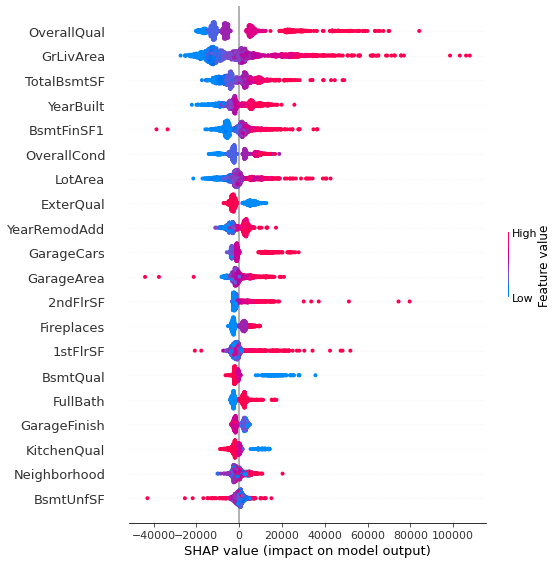

In [33]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary Plot
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

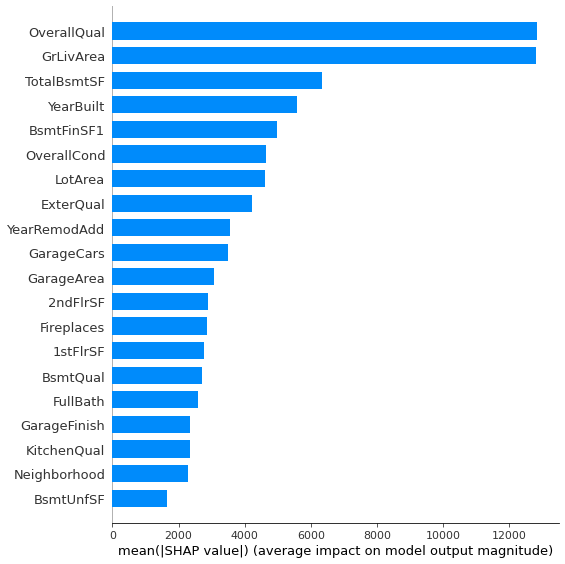

In [34]:
import shap
explainer = shap.TreeExplainer(model)

# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

# Bar Summary Plot
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

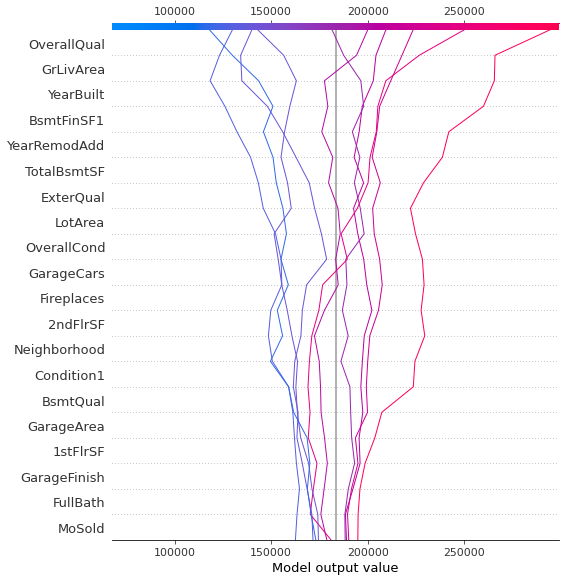

In [35]:
import shap
explainer = shap.TreeExplainer(model)

# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

# Descion plot
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns))

In [36]:
# import matplotlib.pyplot as plt
# import shap
# explainer = shap.TreeExplainer(model)

# # Get expected value and shap values array
# # expected_value = explainer.expected_valuAe
# shap_array = explainer.shap_values(X)

# # Beeswarm Plot
# shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))

In [37]:
# import shap
# explainer = shap.TreeExplainer(model)

# # Get expected value and shap values array
# expected_value = explainer.expected_value
# shap_array = explainer.shap_values(X)

# # Force Plot
# shap.force_plot(expected_value, matplotlib=True)

In [38]:
# import shap
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

# # Heatmap Plot
# shap.plots.heatmap(shap_values, max_display=12)

# Submission

In [39]:
submission=pd.DataFrame({'Id': Id,
                         'SalePrice' : model.predict(test)
                        })
# submission
submission.to_csv('submission.csv', index=False)